# SHAP Analysis and Results

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import shap
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, balanced_accuracy_score, roc_auc_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

/Users/silvanoquarto/Desktop/PROJECTS/Churn-Prediction-Explanation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## SHAP with XGBoost

In [2]:
# Import dataframe 

df = pd.read_excel("Data/CustomerChurn_Transformed.xlsx", index_col=0)
df.head(5)

,Tenure,Monthly Charges,Total Charges,Churn,Senior Citizen_No,Senior Citizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Paperless Billing_No,Paperless Billing_Yes,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,0.000000,0.115423,0.001275,0,1,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
1,0.464789,0.385075,0.215867,0,1,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
2,0.014085,0.354229,0.010310,1,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,0.619718,0.239303,0.210241,0,1,0,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
4,0.014085,0.521891,0.015330,1,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0


In [3]:
# Define input and label then split in training and test

X = df.drop(columns='Churn')
y = df['Churn']

In [4]:
# Initialize stratified k-fold cross-validation

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=59)

In [5]:
# Model training to evaluate Shapley values in Cross-Validation 

shap_values_list = []
expected_values_list = []
indices_list = []

for train_index, test_index in skf.split(X, y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    smote = SMOTE(random_state=59)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    model = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=1000, random_state=59)
    model.fit(X_train_resampled, y_train_resampled)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    expected_values = explainer.expected_value

    shap_values_list.append(shap_values)
    expected_values_list.append(np.repeat(expected_values, len(test_index)))
    indices_list.append(test_index)

In [6]:
# Create a DataFrame with SHAP values and indices

all_shap_values = np.concatenate(shap_values_list, axis=0)
all_expected_values = np.concatenate(expected_values_list, axis=0)
all_indices = np.concatenate(indices_list, axis=0)

shap_df = pd.DataFrame(all_shap_values, index=all_indices, columns=df.drop(columns='Churn').columns)
expected_values_df = pd.DataFrame(all_expected_values, index=all_indices, columns=['Expected_Value'])

shap_df_sorted = shap_df.sort_index()
expected_values_df_sorted = expected_values_df.sort_index()

print("SHAP Values DataFrame Shape:", shap_df_sorted.shape)
shap_df_sorted.head()

SHAP Values DataFrame Shape: (7032, 37)


,Tenure,Monthly Charges,Total Charges,Senior Citizen_No,Senior Citizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,Phone Service_No,...,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Paperless Billing_No,Paperless Billing_Yes,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,0.765064,-0.063706,-0.046335,-0.058162,0.026342,0.004998,-0.003874,-0.022888,0.072870,-0.000704,...,0.162418,0.365892,0.134294,0.122382,0.165462,-0.033404,0.106941,0.133481,-0.169886,0.133877
1,-0.516584,-0.126563,-0.023204,-0.095638,0.048155,-0.027447,0.038860,-0.027118,0.013359,0.000089,...,0.147325,-0.697546,-0.286497,0.228938,-0.442920,0.164196,0.102033,0.084423,0.181937,-0.803734
2,0.488881,-0.085887,-0.047592,-0.088459,0.048155,-0.030943,0.038860,-0.020862,0.039306,-0.000149,...,0.133788,0.363505,0.140455,0.119765,0.158299,-0.040708,0.092488,0.083258,0.187268,-0.638749
3,-0.403619,-0.122323,0.002580,-0.060692,0.037034,-0.089827,0.046335,-0.022675,0.047485,-0.108436,...,0.222999,-0.654437,-0.380021,0.206002,-0.799742,0.415209,-0.751057,0.069759,0.214363,0.143494
4,0.496849,-0.066210,0.031619,-0.047384,0.029318,-0.019394,0.026830,-0.014373,0.015816,-0.000237,...,0.114772,0.479799,0.123320,0.101320,0.135176,-0.025721,0.108651,0.104399,-0.168739,0.165130


In [12]:
# Saving results

shap_df_sorted.to_csv("Results/XGBoost_Shapley_Values_10Fold_CV.csv")
expected_values_df_sorted.to_csv("Results/XGBoost_Expected_Values_10Fold_CV.csv")

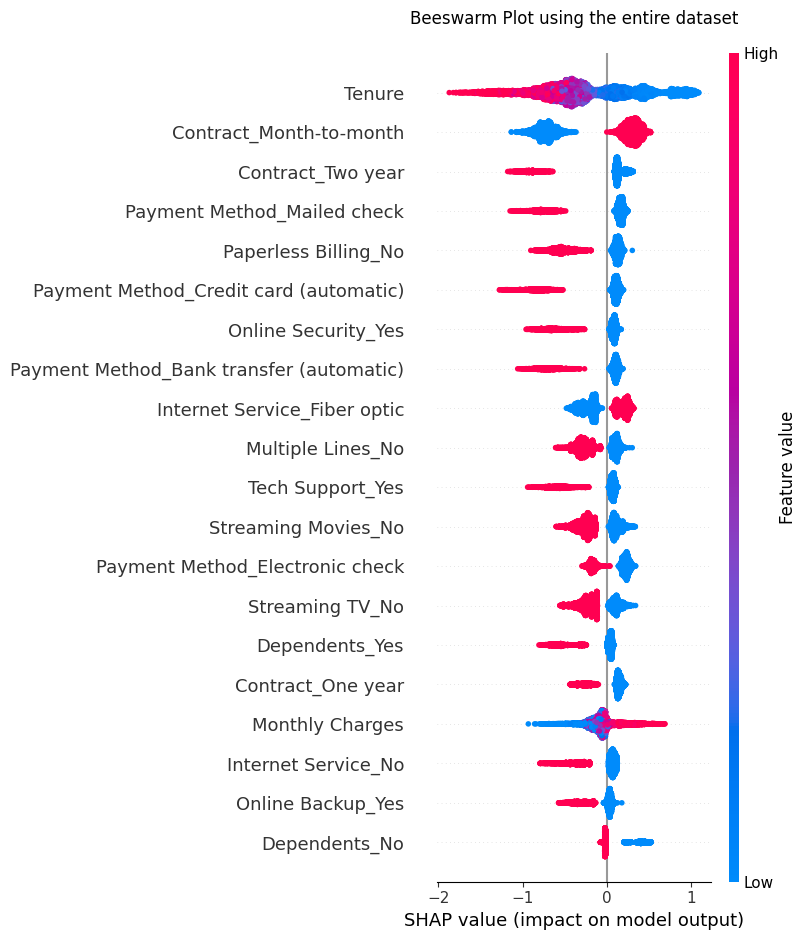

In [27]:
# Results visualization

# Beeswarm plot

plt.title(f"Beeswarm Plot using the entire dataset\n")

shap.summary_plot(shap_df_sorted.values, X, show=False, plot_type="dot")

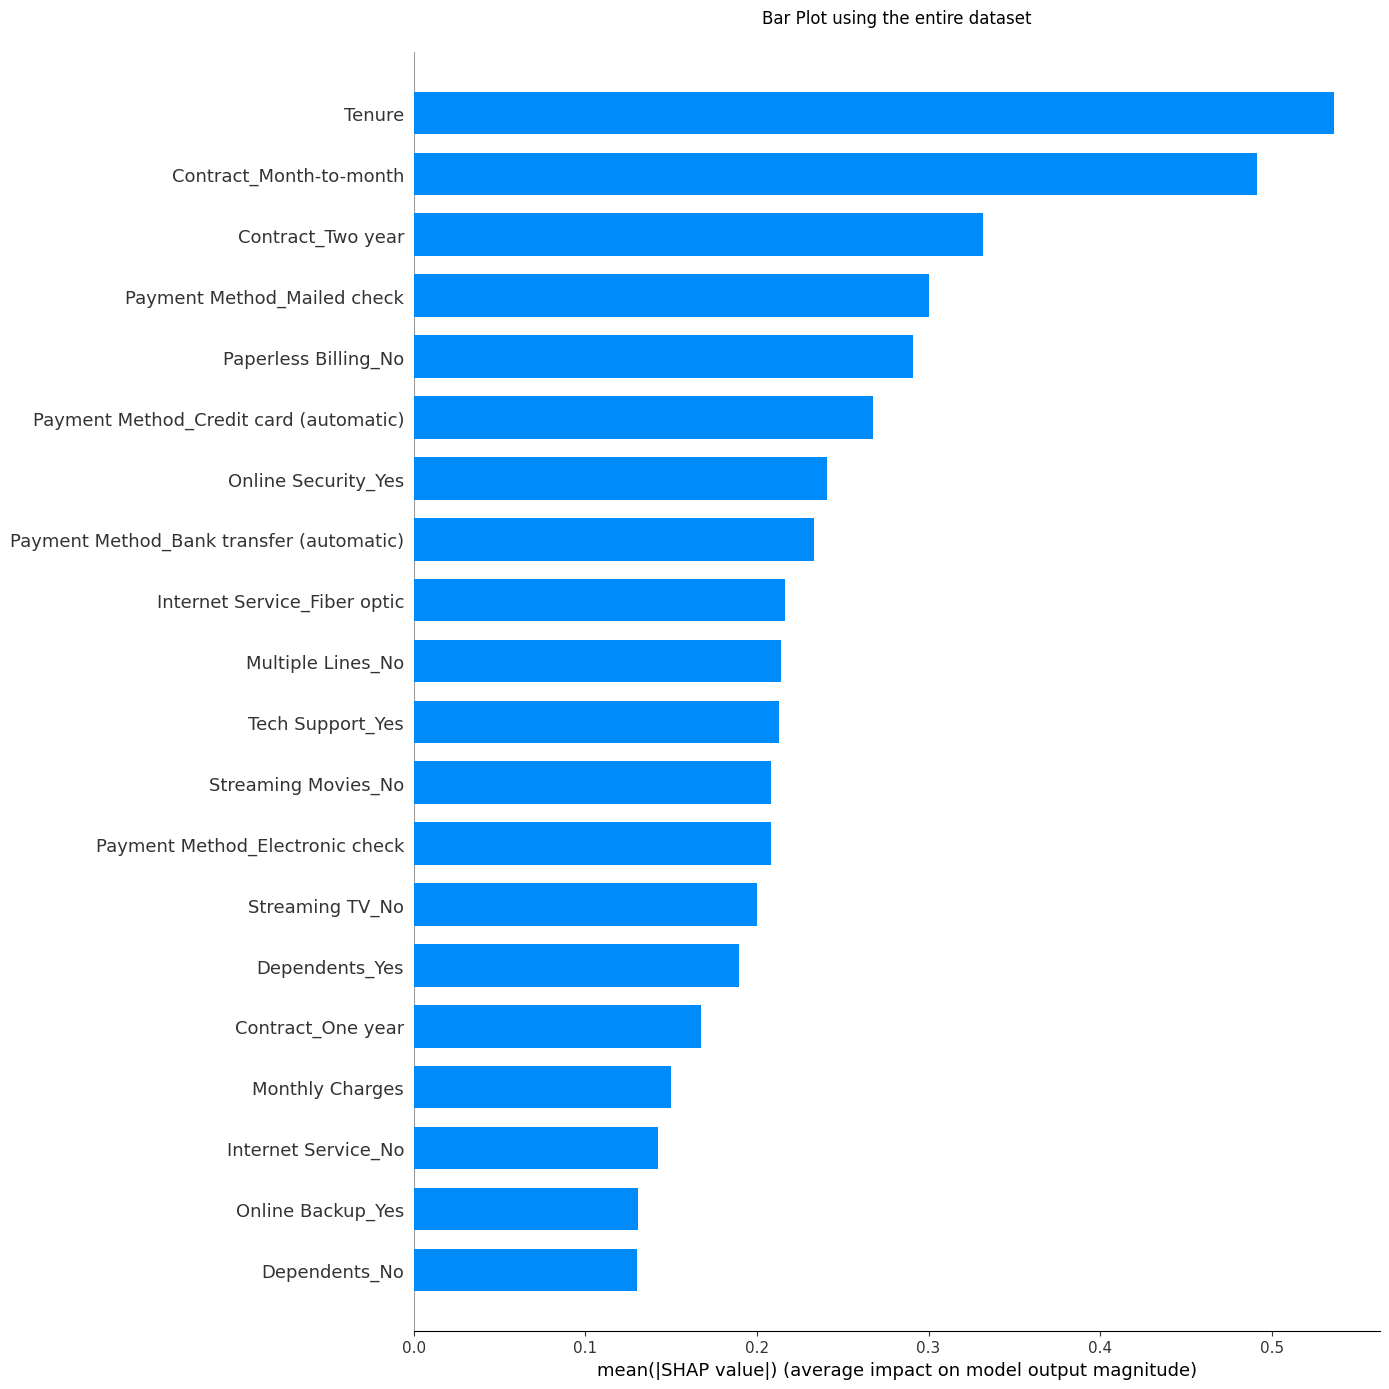

In [26]:
# Bar plot

plt.title(f"Bar Plot using the entire dataset\n")

shap.summary_plot(shap_df_sorted.values, X, plot_type="bar", show=False, plot_size=(14,14))

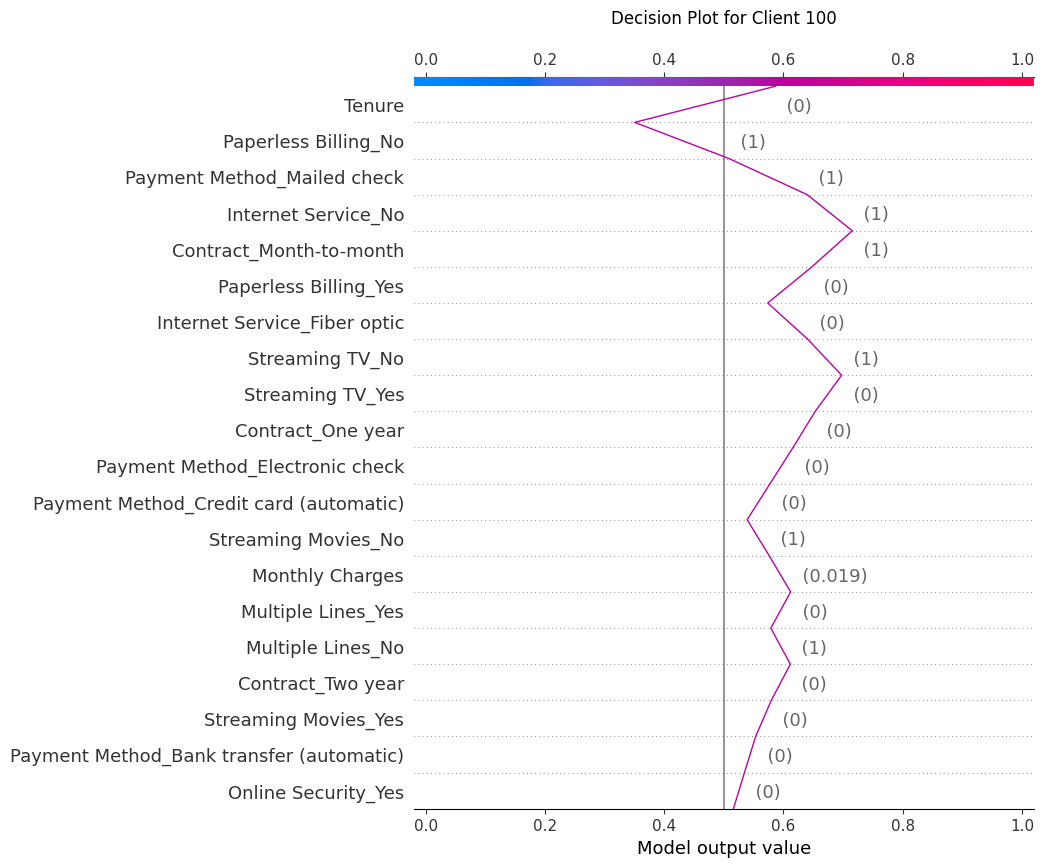

In [25]:
# Local explanation with Decision Plot

client = 100

plt.title(f"Decision Plot for Client {client}\n")

shap.decision_plot(expected_values_df_sorted.iloc[client].values,
                   shap_df_sorted.iloc[client].values, 
                   X.iloc[client,:], 
                   link = 'logit')

In [41]:
# Local Explanation with Force plot

shap.initjs()
shap.force_plot(expected_values_df_sorted.iloc[client].values,
                   shap_df_sorted.iloc[client].values, 
                   X.iloc[client,:], 
                   link = 'logit'
                   )

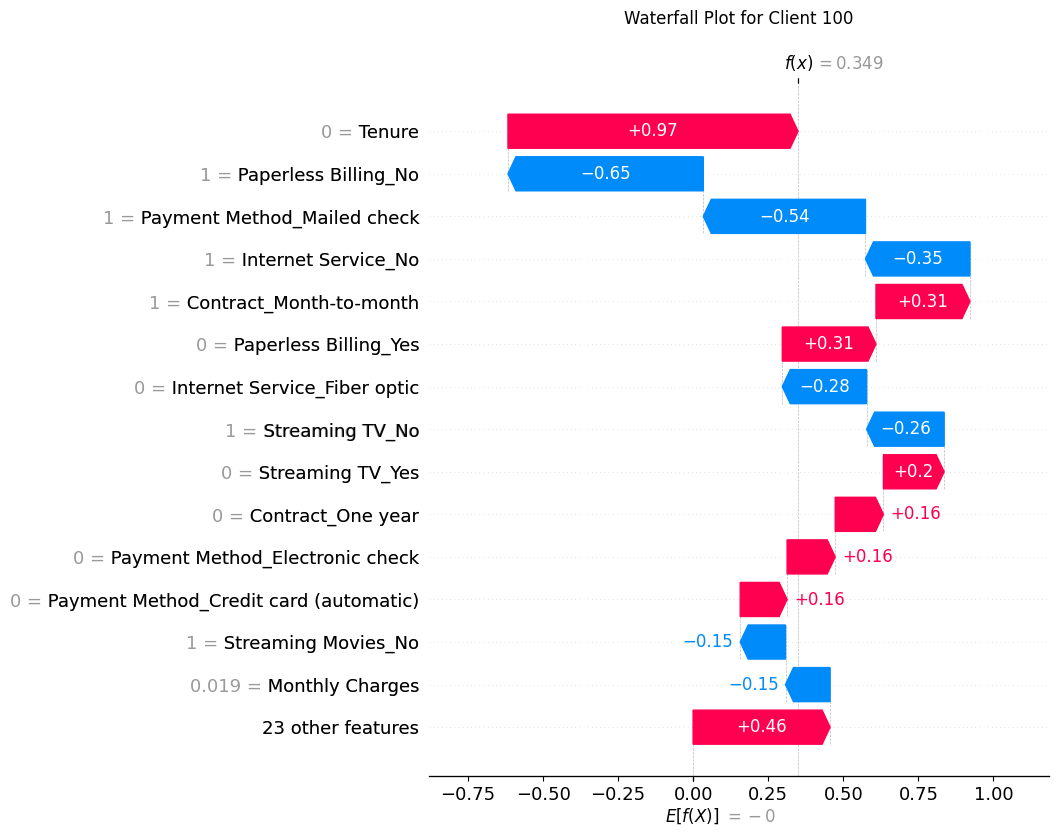

In [44]:
# Local Explanation with Waterfall plot

# For XGBoost the returned units for the Shapley values are in log-odds and Waterfall plot doesn't implement link = 'logit'

exp = shap.Explanation(
    shap_df_sorted.iloc[client].values,
    expected_values_df_sorted.iloc[client].values,
    X.iloc[client,:],
    feature_names=X.columns
)

plt.title(f"Waterfall Plot for Client {client}\n")

shap.waterfall_plot(exp, max_display=15)

## SHAP with CatBoost